# Descripción

*El burnout laboral, también denominado síndrome del quemado o síndrome de estar quemado en el trabajo, es un estado de agotamiento físico, emocional y mental que está vinculado con el ámbito laboral, el estrés causado por el trabajo y el estilo de vida del empleado. Puede tener consecuencias muy graves, tanto en la esfera física como psicológica.*

# Objetivos de la investigación

*Identificar el nivel de burnout a partir del indicador burn rate, que va a partir del 0 al 1, entre valores más altos, más burnout presenta el empleado.*

*Además, se construirá un modelo predictivo teniendo en cuenta que los empleados felices y saludables son indiscutiblemente más productivos en el trabajo y, a su vez, ayudan a que el negocio progrese.*


# Descripción del problema

Atender el problema de burnout en los empleados de cualquier empresa, para mejorar su salud mental, la cual repercute en su desempeño. 

In [570]:
# Importamos librerias

# Librerias de manipulacion
import pandas as pd
from matplotlib.patches import Rectangle
from pandas.api.types import is_numeric_dtype
import numpy as np

# Librerias de visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Librerias de preprocesamiento
from sklearn.impute import KNNImputer

# Libreria de standarizacion de datos
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# Libreria de pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer

# Librerias de randomizacion
import random as rn

# Ignorar errores
import warnings
warnings.filterwarnings('ignore')

# Libreria de modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

# Libreria de seleccion
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV

# Libreria de métricas
from sklearn.metrics import r2_score, median_absolute_error, mean_squared_error, max_error, mean_absolute_error

In [571]:
# Funcion de descripcion del dataset
def dataset_info(x):
  
  '''Calculo de informacion estadistias y genericas de cada columna de un dataframe'''

  # Crear un dataframe con específicas columnas

  df_info = pd.DataFrame(columns=['Count', 'Type' , 'Null', 'Unique', 'Numeric'])

  # Loop de todas las variables del dataframe
  for col in x:

      # Obtengo info de la columna
      data_series = x[col]
      # Lleno dataframe con las columnas iniciales
      df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(), is_numeric_dtype(data_series)]

  # Calculo el describe 
  df_describe = x.describe(include='all').T[['top','freq','mean', 'std', 'min', '25%', '50%', '75%', 'max']]
  
  # Calculo sesgo y curtosis
  df_stats = pd.DataFrame([x.skew(), x.kurtosis()], index=['sesgo', 'kurt']).T

  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('-')

# Significado de cada variable

**Employee ID**: El ID único asignado a cada empleado (ejemplo: fffe390032003000 )

**Date of Joining:** La fecha y hora en que el empleado se unió a la organización (ejemplo: 2008-12-30 )

**Gender:** El género del empleado ( Hombre/Mujer )

**Company Type**: El tipo de empresa donde trabaja el empleado ( Servicio/Producto )

**WFH Setup Available:** ¿Está disponible el trabajo desde casa para el empleado? ( Sí/No )

**Designation:** La designación del empleado de trabajo en la organización.
En el rango de [0.0, 5.0] mayor es la designación mayor.

**Resource Allocation:** La cantidad de recursos asignados al empleado para trabajar, es decir. número de horas de trabajo.
En el rango de [1.0, 10.0] (más alto significa más recursos)

**Mental Fatigue Score:** El nivel de fatiga mental al que se enfrenta el empleado.
En el rango de [0.0, 10.0] donde 0.0 significa sin fatiga y 10.0 significa fatiga total.

**Burn Rate:** El valor que necesitamos predecir para cada empleado indicando la tasa de Burn out mientras trabaja.
En el rango de [0.0, 1.0] donde cuanto más alto es el valor, más se cansa.

In [572]:
df = pd.read_csv("Burn Rate.csv")

info = dataset_info(df)
info

,Count,Type,Null,Unique,Numeric,top,freq,mean,std,min,25%,50%,75%,max,sesgo,kurt
Employee ID,22750,object,0,22750,False,fffe31003300360037003400,1,-,-,-,-,-,-,-,-,-
Date of Joining,22750,object,0,366,False,2008-01-06,86,-,-,-,-,-,-,-,-,-
Gender,22750,object,0,2,False,Female,11908,-,-,-,-,-,-,-,-,-
Company Type,22750,object,0,2,False,Service,14833,-,-,-,-,-,-,-,-,-
WFH Setup Available,22750,object,0,2,False,Yes,12290,-,-,-,-,-,-,-,-,-
Designation,22750,float64,0,6,True,-,-,2.178725,1.135145,0.0,1.0,2.0,3.0,5.0,0.092421,-0.414916
Resource Allocation,21369,float64,1381,10,True,-,-,4.481398,2.047211,1.0,3.0,4.0,6.0,10.0,0.204573,-0.479884
Mental Fatigue Score,20633,float64,2117,101,True,-,-,5.728188,1.920839,0.0,4.6,5.9,7.1,10.0,-0.430895,0.174277
Burn Rate,21626,float64,1124,101,True,-,-,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0,0.045737,-0.261579


In [573]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [574]:
obj = info[(info['Type'] == 'object')].shape[0]
num = info[(info['Type'] != 'object')].shape[0]
print(f'Cantidad de columnas del dataset: {df.shape[1]} \nCantidad de filas del dataset: {df.shape[0]}\nCantidad de columnas tipo object { obj }\nCantidad columnas de tipo numericas {num}')

Cantidad de columnas del dataset: 9 
Cantidad de filas del dataset: 22750
Cantidad de columnas tipo object 5
Cantidad columnas de tipo numericas 4


In [575]:
# Vemos las caracteristicas de las columnas con valores nulos
info[( info.Null > 0 )]

,Count,Type,Null,Unique,Numeric,top,freq,mean,std,min,25%,50%,75%,max,sesgo,kurt
Resource Allocation,21369,float64,1381,10,True,-,-,4.481398,2.047211,1.0,3.0,4.0,6.0,10.0,0.204573,-0.479884
Mental Fatigue Score,20633,float64,2117,101,True,-,-,5.728188,1.920839,0.0,4.6,5.9,7.1,10.0,-0.430895,0.174277
Burn Rate,21626,float64,1124,101,True,-,-,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0,0.045737,-0.261579


In [576]:
# Se elimina los vacios del Burn Rate al ser nuestra columna target
df.dropna(subset=['Burn Rate'],inplace=True)

In [577]:
# Se eliminan las columnas 'Date Of Joining' y 'Employee ID' para el analisis.
dff = df.drop(['Date of Joining','Employee ID'],axis=1)

                      Porcentaje  Cantidad
Mental Fatigue Score        8.99      1945
Resource Allocation         5.91      1278


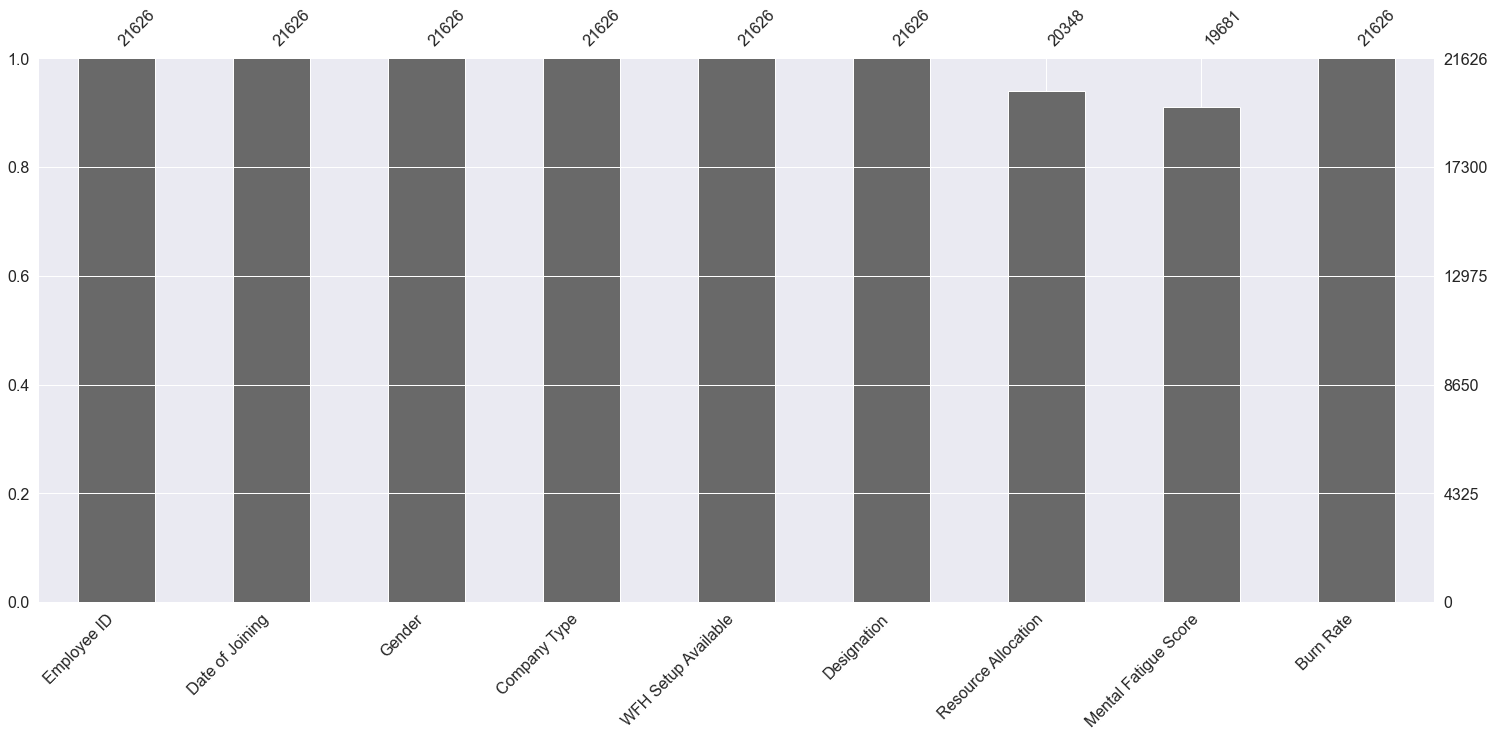

In [591]:
# Vista de los valores nulos, columnas segun cantidad y porcentaje del total de observaciones del dataset
msno.bar(df);
valores_perdidos = pd.DataFrame({
    'Porcentaje': round(df.isnull().sum() * 100 / len(df),2),
    'Cantidad':df.isnull().sum()
}).sort_values(by='Cantidad',ascending=False)
print(valores_perdidos[ (valores_perdidos.Cantidad > 0) ])

# Procedimiento de llenado de nulos

* Se utilizara la aplicacion del KNNImputer para rellenar los valores nulos.

*KNNimputer es una clase de scikit-learn que se utiliza para completar o predecir los valores faltantes en un conjunto de datos. Es un método más útil que funciona con el enfoque básico del algoritmo KNN en lugar del enfoque de completar todos los valores con la media o la mediana. En este enfoque, especificamos una distancia de los valores perdidos que también se conoce como el parámetro K. El valor faltante se predecirá en referencia a la media de los vecinos.*

In [537]:
# funcion para aplicacion de one hot encoding, standarizacion de valores y rellenado de nulos con KNNImputer

def llenado_nulos(x):
    
    # Aplicamos el One Hot Encoding.
    columnas = ['Gender','Company Type','WFH Setup Available']
    x_encoder = pd.get_dummies(x[columnas])
    # Eliminamos las columnas object que ya se aplico el One Hot Encoding
    ohe = pd.concat([ x, x_encoder],axis=1).drop(columnas,axis=1)

    # Estandarizamos las escalas de las columnas para que todas tengan los mismos rango de pesos.
    standar = StandardScaler()
    escalado = standar.fit_transform(ohe)
    escalado = pd.DataFrame(data=escalado,columns=ohe.columns)

    # Instanciamos el imputador
    imputer = KNNImputer(
        missing_values=np.nan,
        n_neighbors=5,
        weights='uniform',
        metric="nan_euclidean",
        copy=True,
        add_indicator=False,
    )

    # Generamos un pandas series con la transformacion
    datos_imputados = imputer.fit_transform(escalado)

    # Volvemos los datos a la normalidad del dataset original.
    df_rellenado = pd.DataFrame(data=standar.inverse_transform(datos_imputados),columns=escalado.columns)
    
    return df_rellenado

In [538]:
# Invocamos la funcion para llenar los nulos
df_rellenado = llenado_nulos(dff)
df_rellenado.head()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,2.0,3.0,3.8,0.16,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,2.0,5.0,0.36,0.0,1.0,0.0,1.0,0.0,1.0
2,2.0,4.0,5.8,0.49,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,2.6,0.20,0.0,1.0,0.0,1.0,0.0,1.0
4,3.0,7.0,6.9,0.52,1.0,0.0,0.0,1.0,1.0,0.0


### Correlacion


*Planteamos la hipótesis de que podría existir algún tipo de dependencia de una variable con respecto a la otra. 
Si este tipo de dependencia existe, queremos ver de qué forma se da esa relación.*

En este caso analizaremos todas las relaciones pero la correlacion mas importante son las variables vs el target (Burn Rate)

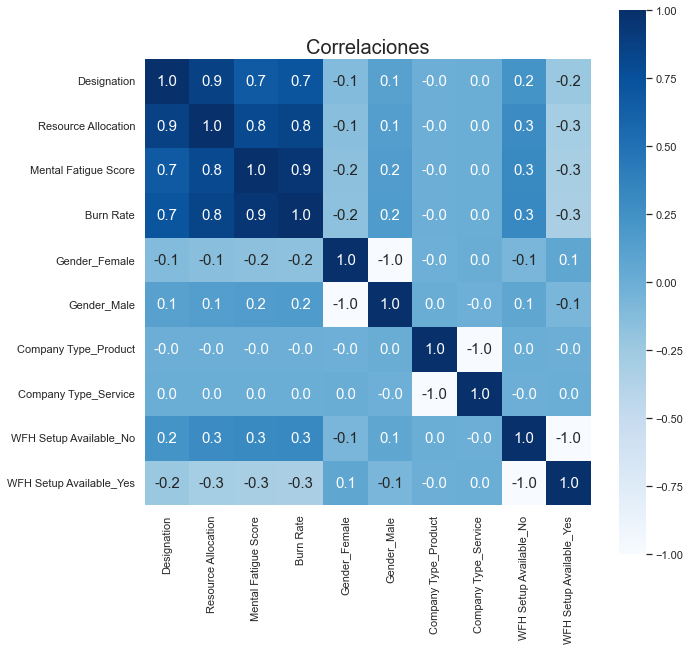

In [592]:
# Vemos la correlacion entre las variables
corr = df_rellenado.corr('spearman')

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Blues')
plt.title('Correlaciones');

### Conclusiones

*Pareciera que las variables tienen una fuerte correlación positiva, y si lo pensamos en términos de dependencia, quiere decir que cuando la variable x aumenta, entonces también lo hace la variable y, y viceversa.*


In [540]:
# Funcion para ordenar las correlaciones de las variables de mayor a menor
def corrFilter(x: pd.DataFrame, thres: float):
    # Generate corr 
    xCorr = x.corr('spearman')
    # Filter corr by thres
    xFiltered = xCorr[((xCorr >= thres) | (xCorr <= -thres)) & (xCorr !=1.000)]
    # Change dataframe format
    xFlattened = xFiltered.unstack().drop_duplicates().reset_index().sort_values(0, ascending= False).dropna()
    # Rename columns
    xFlattened.columns = ['Variable_1', 'Variable_2', 'corr_value']
    return xFlattened

corrFilter(df, .7)

x = df.corr('spearman')
y = x[((x >= 0.7) | (x <= -0.7)) & (x !=1.000)]

y.unstack().drop_duplicates().reset_index().sort_values(0, ascending= False).dropna()

,level_0,level_1,0
5,Mental Fatigue Score,Burn Rate,0.943992
1,Designation,Resource Allocation,0.870376
4,Resource Allocation,Burn Rate,0.847835
3,Resource Allocation,Mental Fatigue Score,0.797884
2,Designation,Burn Rate,0.718205


In [541]:
def hist_tick(x:pd.DataFrame,col): 

    fig , axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(22,8))

    # Grafico basico
    sns.set_theme(rc={"font.size":9,"axes.titlesize":20,"axes.labelsize":15})
    sns.histplot(data=x, x=col, ax=axes[0], bins='sturges',kde=False);
    axes[0].tick_params(axis='x', rotation=70)


    # Extraccion de la variable
    data = x[col]

    # Cambio de colores por percentil
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    #generacion de grafico en base a sturges
    counts, bins, patches = axes[1].hist(data, facecolor=perc_50_colour, edgecolor='gray', bins='sturges')

    #seteo de la variable x en su anotacion
    axes[1].set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Genereo titulo y nombre de eje
    plt.xlabel(col, fontsize=15)

    # Calculo de percentiles
    q25, q75, q95 = np.percentile(data, [25, 75, 95])

    # Asignacion de colores segun barra y los valores de los percentiles
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside <= q25:
            patch.set_facecolor(perc_25_colour)
        elif leftside > q95:
            patch.set_facecolor(perc_95_colour)
        elif leftside >= q75:
            patch.set_facecolor(perc_75_colour)

    # Ubicaion central de los eje de la barras x
    bin_x_centers = 0.1 * np.diff(bins) + bins[:-1]

    # Display de las anotaciones de cada barra en porcentaje
    for i in range(len(bins)-1):
        bin_label = "({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i] , counts[i], bin_label, rotation_mode='anchor')

    # Creacion de leyenda
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99));

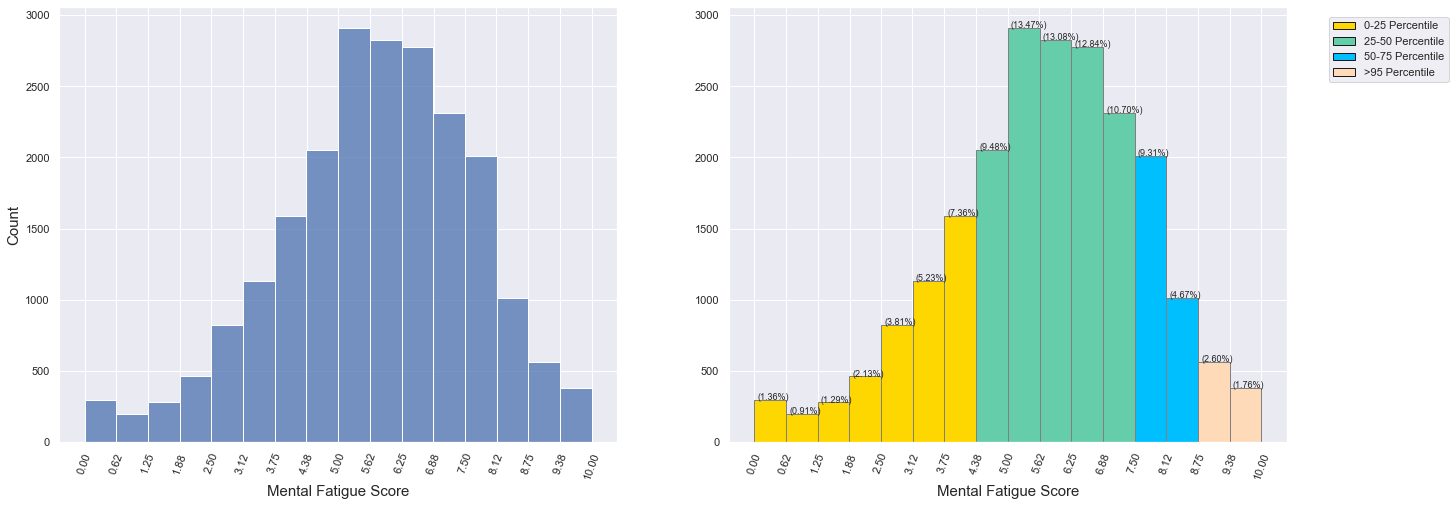

In [542]:
hist_tick(x=df_rellenado,col='Mental Fatigue Score')

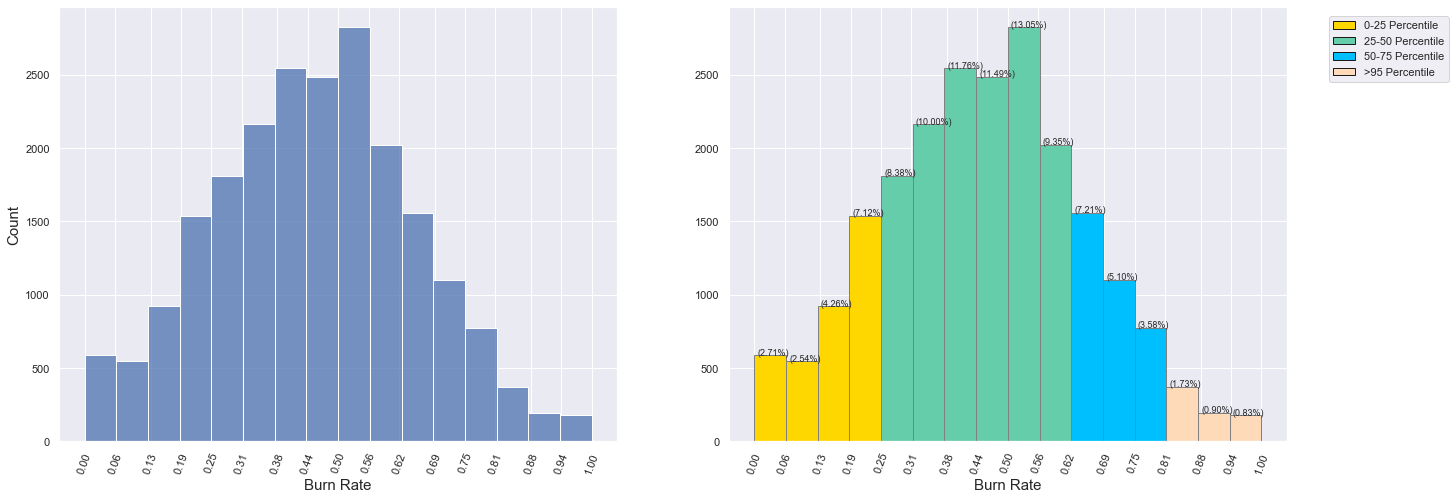

In [543]:
hist_tick(x=df_rellenado,col='Burn Rate')

### Conclusiones

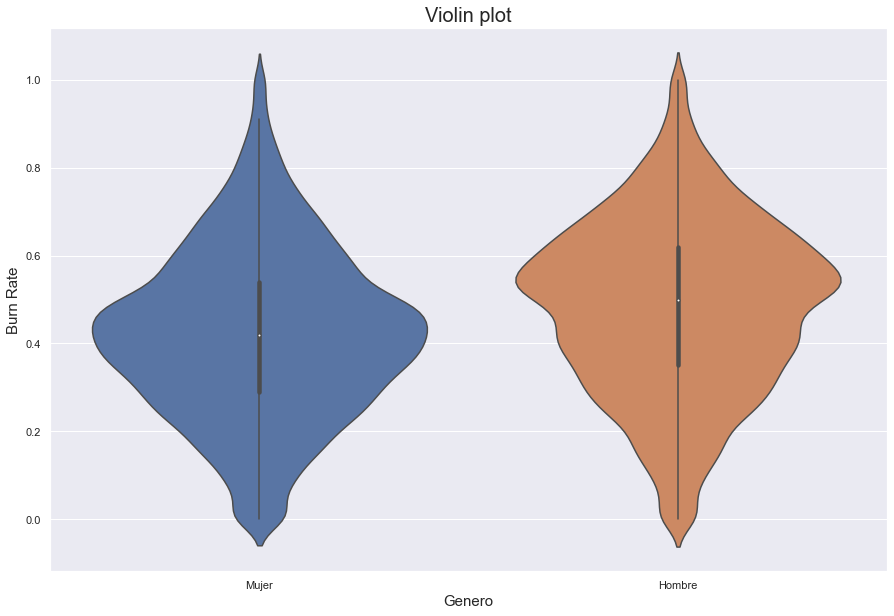

In [544]:
plt.figure(figsize=(15,10))
fig = sns.violinplot(x = 'Gender_Male', y='Burn Rate', data=df_rellenado)
fig.set(title='Violin plot',xlabel='Genero')
fig.set_xticklabels(['Mujer','Hombre']);

### Conclusiones

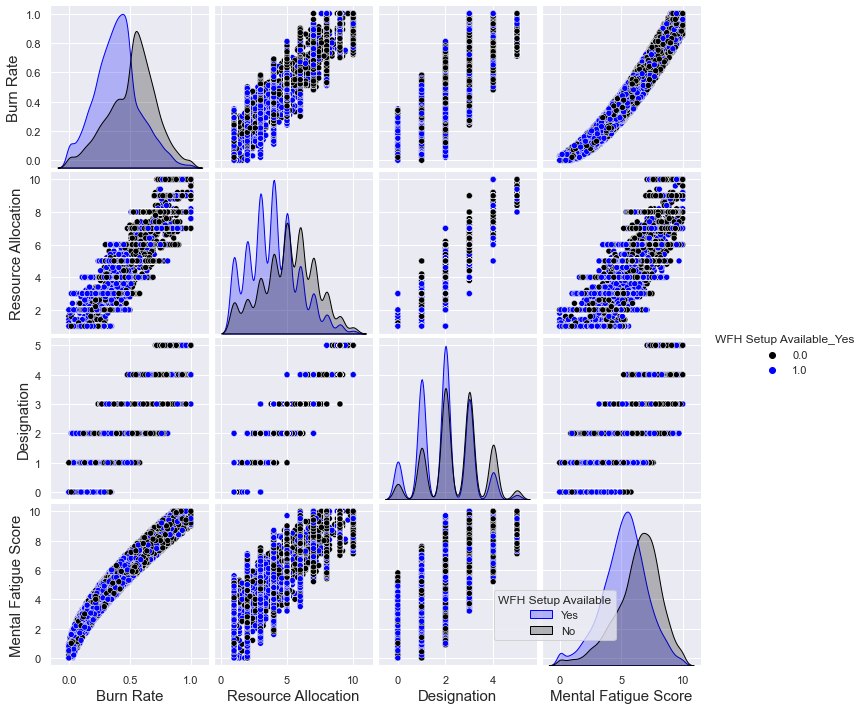

In [545]:
graph = sns.pairplot(
    df_rellenado[['Burn Rate','Resource Allocation','Designation','Mental Fatigue Score','WFH Setup Available_Yes']],
    hue='WFH Setup Available_Yes',
    hue_order=None, palette=['black','blue'],
    vars=None, x_vars=None, y_vars=None,
    kind="scatter", diag_kind="auto", markers=None,
    height=2.5, aspect=1, corner=False, dropna=False,
    plot_kws=None, diag_kws=None, grid_kws=None, size=None,    
)

plt.legend(
  bbox_to_anchor=(0.5,0.5),
  title='WFH Setup Available',
  labels=['Yes', 'No']
)

plt.show(graph)

In [546]:
# Separo entre features y target.
X = df.drop(['Employee ID','Date of Joining','Burn Rate'],axis=1)
y = df['Burn Rate']

In [547]:
# Separo el dataset en Train y Test.
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.3,random_state=42,stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15138, 6) (15138,) (6488, 6) (6488,)


In [548]:
# Obtener columnas categoricas y numericas
cat_col = X_train.select_dtypes(include='O').columns.tolist()
print('Categoricas --> ',cat_col)
num_col = X_train.select_dtypes(exclude='O').columns.tolist()
print('Numericas --> ',num_col)

Categoricas -->  ['Gender', 'Company Type', 'WFH Setup Available']
Numericas -->  ['Designation', 'Resource Allocation', 'Mental Fatigue Score']


In [549]:
# Generar a pipeline para numericas 
numeric_transformer = Pipeline(
    steps=[
        ('imputation',KNNImputer( 
            missing_values=np.nan, 
            n_neighbors=5, 
            weights='uniform', 
            metric="nan_euclidean",
            copy=False,
            add_indicator=False,
            )
        ),
        ('StandardScaler', StandardScaler())        
    ]
)

# Generar un pipeline para categoricas
categorical_transformer = Pipeline(
    steps=[
        ("ohe",OneHotEncoder(drop='first',handle_unknown='ignore')),
    ]
)

# Funcion que realiza el trabajo para cada pipeline y luego unirlo
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, make_column_selector(dtype_include = object),),
        ('num', numeric_transformer, make_column_selector(dtype_include = np.number)),
    ], remainder='drop'
)


# Obtencion de los procesos en el X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C20A233CD0>),
                                ('num',
                                 Pipeline(steps=[('imputation',
                                                  KNNImputer(copy=False)),
                                                 ('StandardScaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C20A233850>)])

In [550]:
# Aplico la transformacion al X_train con los pipelines procesados.
X_array_enc = preprocessor.transform(X_train)

In [551]:
# Transformacion de X_train 
X_array_enc = preprocessor.transform(X_train)
X_train_enc = pd.DataFrame(X_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_train.index)

In [552]:
# Transformacion de X_test
X_test_array_enc = preprocessor.transform(X_test)
X_test_enc = pd.DataFrame(X_test_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_test.index)

In [553]:
# Usamos mismas semillas

randomState = 45
Num_estimators = 100
jobs = -1
maxDepth = 10
maxFeature = None

name_model=[]
models = []
r2 = []
m = []
mae = []
mse = []
rss = []
rmse = []
train_value = []
test_value =[]
predict_value = []
residuo_value = []
meanAbsoluteError = []

# Instanciamos los algoritmos a utilizar
lr = LinearRegression(
    fit_intercept=True,
    normalize="deprecated",
    copy_X=True,
    n_jobs=jobs,
    positive=False,
)

rf = RandomForestRegressor(
    n_estimators=Num_estimators,
    criterion="squared_error",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=jobs,
    random_state=randomState,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)

knr = KNeighborsRegressor(
    n_neighbors=5,
    weights="uniform",
    algorithm="auto",
    leaf_size=30,
    p=2,
    metric="minkowski",
    metric_params=None,
    n_jobs=jobs,
)

gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    n_estimators=Num_estimators,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=maxDepth,
    min_impurity_decrease=0.0,
    init=None,
    random_state=randomState,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=1e-4,
    ccp_alpha=0.0,    
)

dtr= DecisionTreeRegressor(
    criterion="squared_error",
    splitter="best",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=randomState,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,    
)


xgb = XGBRegressor(
    objective= 'reg:squarederror',
    base_score= None,
    booster= None,
    callbacks= None,
    colsample_bylevel= None,
    colsample_bynode= None,
    colsample_bytree= None,
    early_stopping_rounds= None,
    enable_categorical= False,
    eval_metric= None,
    gamma= None,
    gpu_id= None,
    grow_policy= None,
    importance_type= None,
    interaction_constraints= None,
    learning_rate= None,
    max_bin= None,
    max_cat_to_onehot= None,
    max_delta_step= None,
    max_depth= None,
    max_leaves= None,
    min_child_weight= None,
    monotone_constraints= None,
    n_estimators= 100,
    n_jobs= jobs,
    num_parallel_tree= None,
    predictor= None,
    random_state= randomState,
    reg_alpha= None,
    reg_lambda= None,
    sampling_method= None,
    scale_pos_weight= None,
    subsample= None,
    tree_method= None,
    validate_parameters= None,
    verbosity= None    
)

lgb = LGBMRegressor(
    boosting_type= 'gbdt',
    class_weight= None,
    colsample_bytree= 1.0,
    importance_type= 'split',
    learning_rate= 0.1,
    max_depth= -1,
    min_child_samples= 20,
    min_child_weight= 0.001,
    min_split_gain= 0.0,
    n_estimators= 100,
    n_jobs= jobs,
    num_leaves= 31,
    objective= None,
    random_state= randomState,
    reg_alpha= 0.0,
    reg_lambda= 0.0,
    silent= 'warn',
    subsample=1.0,
    subsample_for_bin= 200000,
    subsample_freq= 0    
)


In [554]:
# Carga de modelos.

models.append(lr)
models.append(rf)
models.append(knr)
models.append(gbr)
models.append(dtr)
models.append(xgb)
models.append(lgb)

In [555]:
# Entrenamiento de modelos y generacion de metricas de regresion.

for model in models:
    
    # Nombre Modelo
    name_model.append(model.__class__.__name__)

    # Entreno Modelo
    model.fit(X_train_enc,y_train)
    
    # Prediccion
    y_predict = model.predict(X_test_enc)

    # Metricas

    # Error absoluto máximo
    m.append(max_error(y_test,y_predict))
    
    # R2
    r2.append(model.score(X_train_enc,y_train))

    # mean_absolute_error
    meanAbsoluteError.append(mean_absolute_error(y_test,y_predict))

    # MAE (Median Absolute Error)
    mae.append(median_absolute_error(y_test,y_predict))

    # Mean Squared Error
    mse.append(mean_squared_error(y_test,y_predict))

    # Suma de los cuadrados de los residuos
    rss.append(mean_squared_error(y_test,y_predict)*len(y_predict))

    # Suma de los cuadrados de los residuos
    rmse.append(mean_squared_error(y_test,y_predict,squared=False))

    # Valores de Train
    train_value.append(y_train)

    # Valores Test
    test_value.append(y_test)

    # Valores Prediccion
    predict_value.append(y_predict)

    # Diferencia
    residuo_value.append(y_test - y_predict)


In [556]:
# Listar resultados
resultados = {
    'Nombre_modelo':name_model,
    'Modelos':models,
    'M':m,
    'EAM': meanAbsoluteError,
    'R2':r2,
    'MAE':mae,
    'MSE':mse,
    'RSS':rss,
    'RMSE':rmse,
    'Test': test_value,
    'Predict': predict_value,
    'Residuo': residuo_value
}

# Comparacion de algoritmos por sus metricas

***
### Metricas usadas para algoritmo de regresion.
***

##### Los modelos de regresión es casi imposible predecir el valor exacto, sino que más bien se busca estar lo más cerca posible del valor real, por lo que la mayoría de las métricas, con sutiles diferencias entre ellas, van a centrarse en medir eso: lo cerca (o lejos) que están las predicciones de los valores reales.

##### En los modelos de regresión hay que considerar los valores anómalos y si queremos penalizar errores grandes o no.

***

*Ejemplo para entender las metricas.*

##### *y_verdadero = [1,2,3,4,5]*
##### *y_predicho = [1,2,3,4,-5]*


##### R cuadrado o coeficiente de determinacion, *Evalua que tan bien se ajusta nuestro modelo a los datos. Valor segun array ejemplo = <b>*

##### M: Error absoluto máximo, *muestra el error absoluto maximo de toda las observaciones. Valor segun array ejemplo = <b> 10*

##### MAE: Error absoluto medio, *Es el promedio de la suma de los residuos absolutos entre el array del valor predicho y el valor verdadero. Castiga menos a los numeros chicos. Valor segun array ejemplo = <b>2*

##### MSE: Error cuadrático medio. *Es el promedio de la suma del cuadrado de los residuos entre el array del valor predicho y el valor verdadero, lo que hace elevarlo al cuadrado aumenta el peso de los errores grandes que los errores pequeños. Valor segun array ejemplo = <b>20*

##### RSS: Suma de los cuadrados de los residuos. *Es la suma del cuadrado de los residuos entre el array del valor predicho y el valor verdadero. Valor segun array ejemplo = <b>100*

##### RMSE: Raíz cuadrada del error cuadrático medio. *Es el MSE pero agregado la raiz para nos indique en la unidad de nuestro modelo de regresion. Valor segun array ejemplo = <b>4.47213...*

In [557]:
# Crear Dataframe con los resultados
df = pd.DataFrame(resultados)
df

,Nombre_modelo,Modelos,M,EAM,R2,MAE,MSE,RSS,RMSE,Test,Predict,Residuo
0,LinearRegression,LinearRegression(n_jobs=-1),0.332869,0.049035,0.902022,0.041659,0.003838,24.898500,0.061949,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.5028523684000425, 0.5923226902261961, 0.123...",7349 0.097148 7327 0.127677 3907 0...
1,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.326783,0.046403,0.923246,0.038805,0.003516,22.814162,0.059299,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.49673070828092036, 0.597266034513743, 0.139...",7349 0.103269 7327 0.122734 3907 0...
2,KNeighborsRegressor,KNeighborsRegressor(n_jobs=-1),0.362000,0.049999,0.922354,0.040000,0.004135,26.826968,0.064303,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.46799999999999997, 0.586, 0.138, 0.67799999...",7349 0.132 7327 0.134 3907 0.002 4...
3,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,0.328961,0.049020,0.935826,0.040964,0.003947,25.608614,0.062826,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.4989034940076096, 0.597038902215222, 0.1344...",7349 0.101097 7327 0.122961 3907 0...
4,DecisionTreeRegressor,"DecisionTreeRegressor(max_depth=10, random_sta...",0.317439,0.047615,0.919891,0.040000,0.003703,24.026113,0.060854,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.48830188679245295, 0.6109523809523809, 0.12...",7349 0.111698 7327 0.109048 3907 0...
5,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.325959,0.046734,0.924773,0.039444,0.003558,23.085923,0.059651,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.49618137, 0.5939472, 0.14521822, 0.7578745,...",7349 0.103819 7327 0.126053 3907 -0...
6,LGBMRegressor,LGBMRegressor(random_state=45),0.329254,0.046416,0.917457,0.039289,0.003489,22.634409,0.059065,7349 0.60 7327 0.72 3907 0.14 4377...,"[0.4976910371337514, 0.5996158631876306, 0.138...",7349 0.102309 7327 0.120384 3907 0...


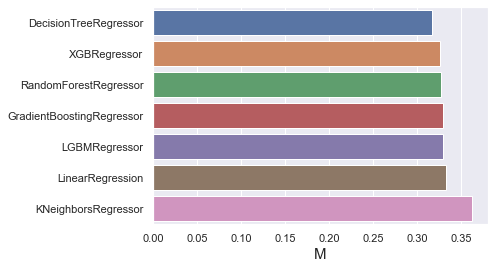

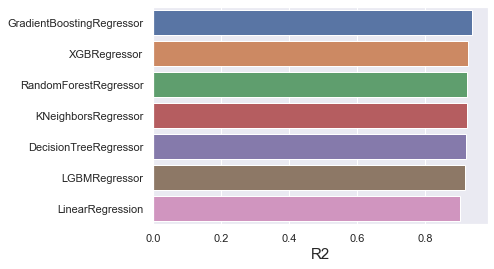

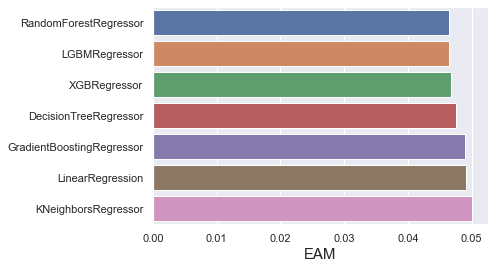

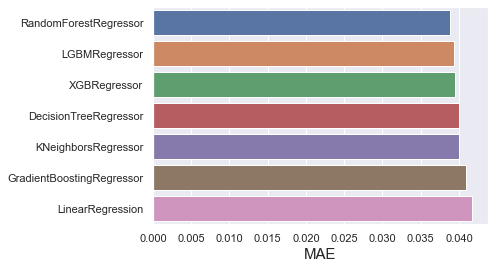

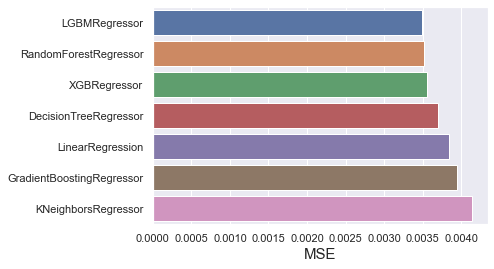

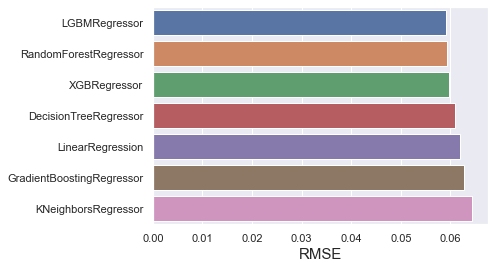

In [558]:
# Vista de metricas
 
metrics=['M','R2','EAM','MAE','MSE','RMSE']

for i in metrics:
    if i == 'R2':
        _df_ = df[['Nombre_modelo',f'{i}']].sort_values(by=[f'{i}'],ascending=False)
    else:
        _df_ = df[['Nombre_modelo',f'{i}']].sort_values(by=[f'{i}'],ascending=True)
    
    sns.set_theme(rc={"font.size":9,"axes.titlesize":20,"axes.labelsize":15})
    sns.barplot(
        x=f'{i}', y='Nombre_modelo',
        hue=None, data=_df_,
        order=None, hue_order=None,
        estimator=np.mean, ci=95, n_boot=1000, units=None, seed=None,
        orient=None, color=None, palette=None, saturation=.75,
        errcolor=".26", errwidth=None, capsize=None, dodge=True,
        ax=None      
    )
    
    plt.ylabel('')
    plt.show()

In [559]:
# Funcion de generacion de residuos por metrica
def plot_diagnostic(df_):
    for i in range(df_.count()[0]):

        nombre_modelo= df_['Nombre_modelo'][i]
        df_new = pd.DataFrame( pd.Series(df_.Test[0]) ).reset_index().rename(columns={'index':'index_value','Burn Rate':'Real'})
        Predict = pd.DataFrame( pd.Series(df_.Predict[0]) ).rename(columns={0:'Predict'})
        Residue= pd.DataFrame( pd.Series(df_.Residuo[0]) ).reset_index().rename(columns={'index':'index_value','Burn Rate':'Residuo'})

        Predict['index_value'] = df_new['index_value']

        df_new = df_new.merge(Predict,how='left')
        df_new = df_new.merge(Residue, how= 'left')

        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))

        ax[0].scatter(
            df_new['Predict'], 
            df_new['Real'], 
            edgecolors='face', 
            alpha = 0.2
        )

        ax[0].plot(
            [df_new['Real'].min(), df_new['Real'].max()], 
            [df_new['Real'].min(), df_new['Real'].max()],
            'k--', 
            color = 'black', 
            lw=2
        )
        ax[0].set_title('Valor predicho vs valor real', fontsize = 12, fontweight = "bold")
        ax[0].set_xlabel('Real')
        ax[0].set_ylabel('Predicción')
        ax[0].tick_params(labelsize = 10)

        ax[1].scatter(
            x=list(range(len(df_new['Real']))), 
            y=df_new['Residuo'],
            edgecolors='face', 
            alpha = 0.2
        )

        ax[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
        ax[1].set_title('Dispersión de residuos', fontsize = 12, fontweight = "bold")
        ax[1].set_xlabel('id')
        ax[1].set_ylabel('Residuo')
        ax[1].tick_params(labelsize = 7)

        sns.histplot(
            data    = df_new['Residuo'],
            stat    = "count",
            kde     = True,
            line_kws= {'linewidth': 2},
            color   = "firebrick",
            alpha   = 0.2,
            ax      = ax[2]
        )

        ax[2].set_title('Distribución de residuos', fontsize = 12,fontweight = "bold")
        ax[2].set_xlabel("Residuo")
        ax[2].tick_params(labelsize = 7)

        fig.tight_layout()
        plt.subplots_adjust(top=0.9)
        fig.suptitle(f'Diagnóstico residuos: {nombre_modelo}', fontsize = 20, fontweight = "bold");
        fig.show()

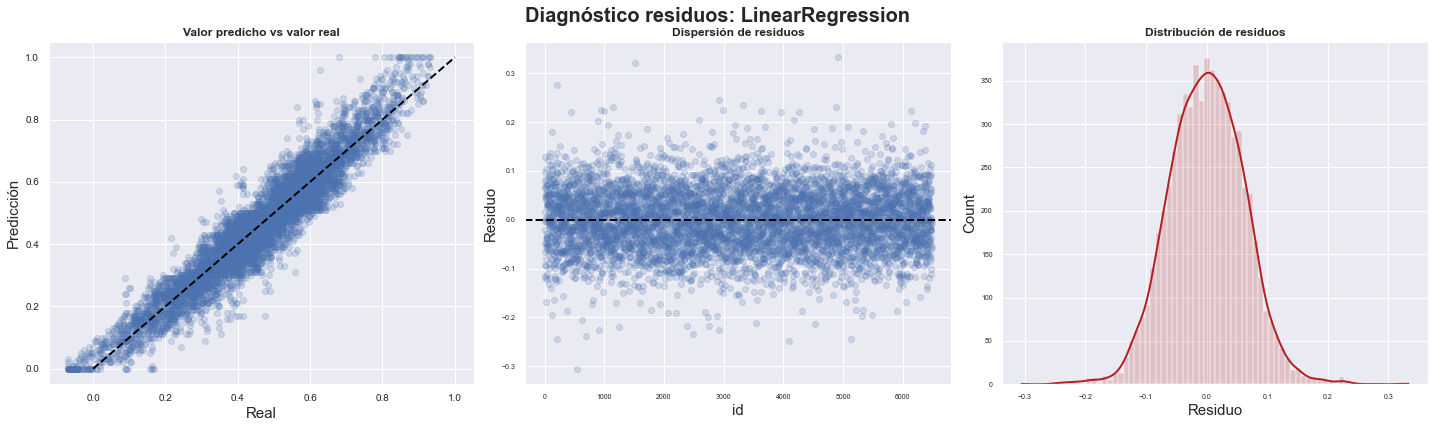

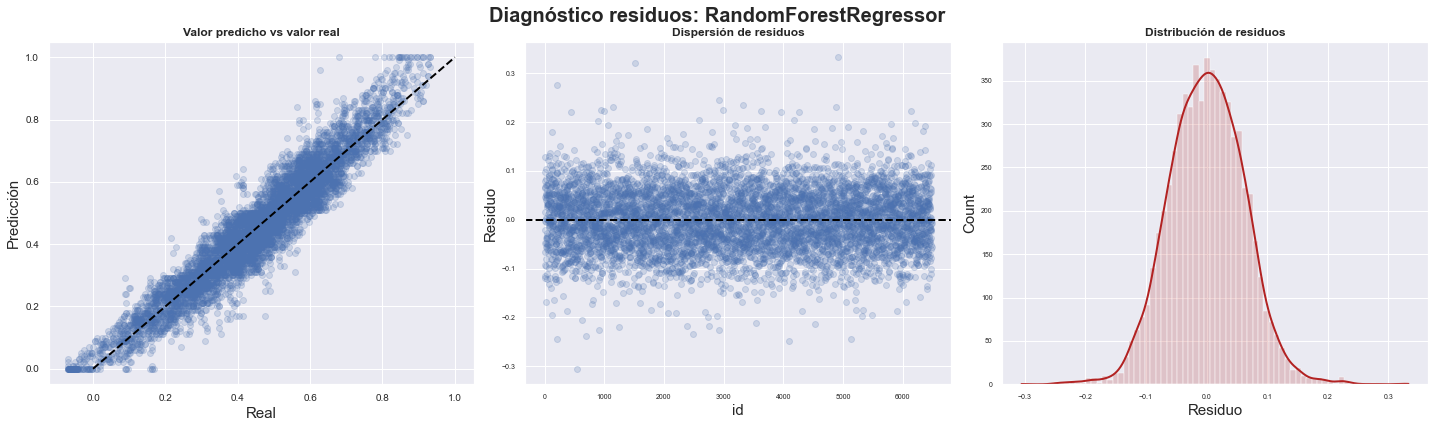

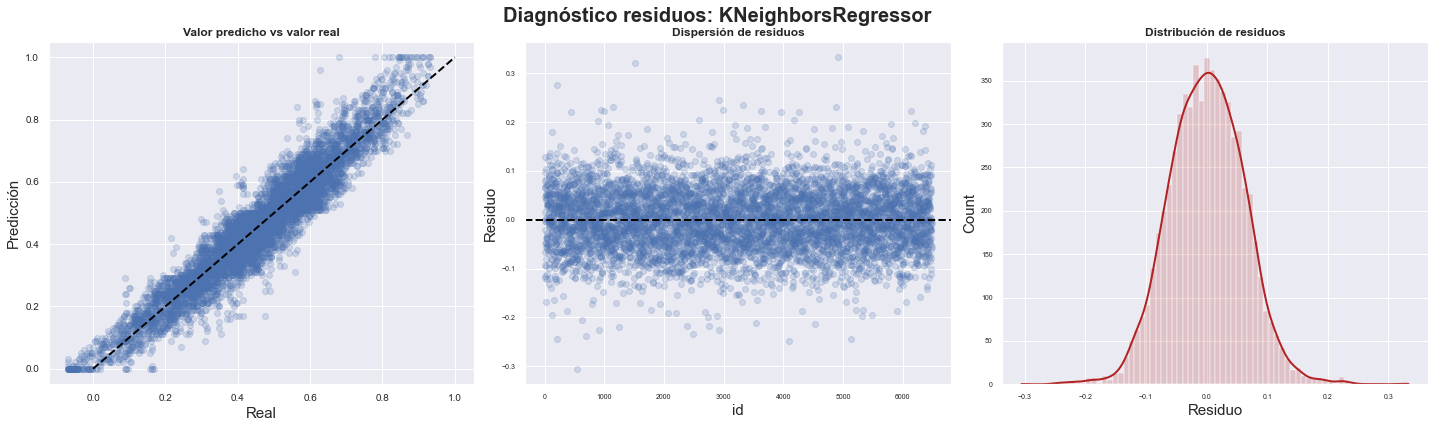

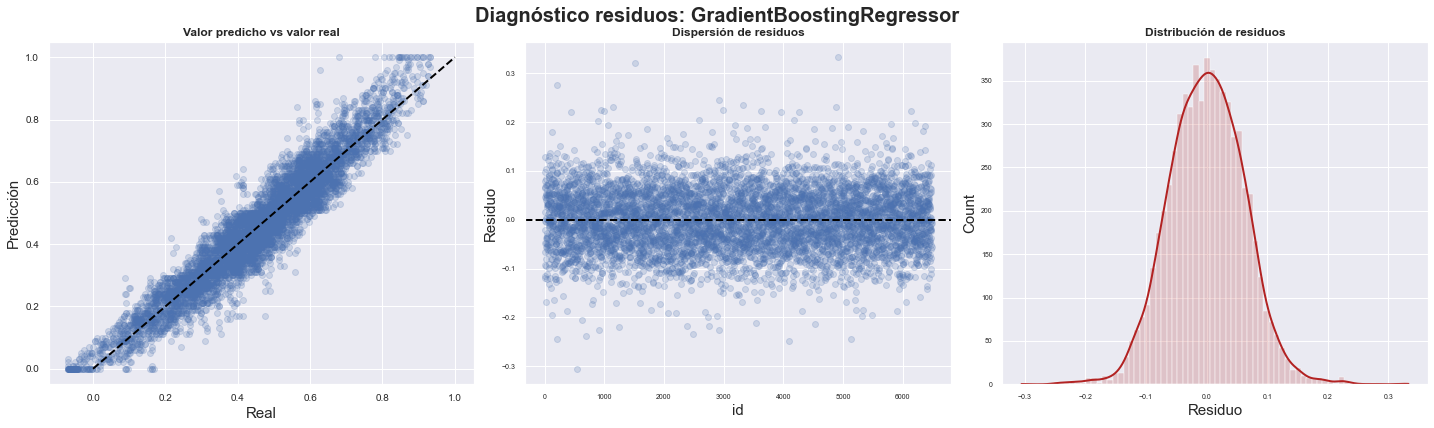

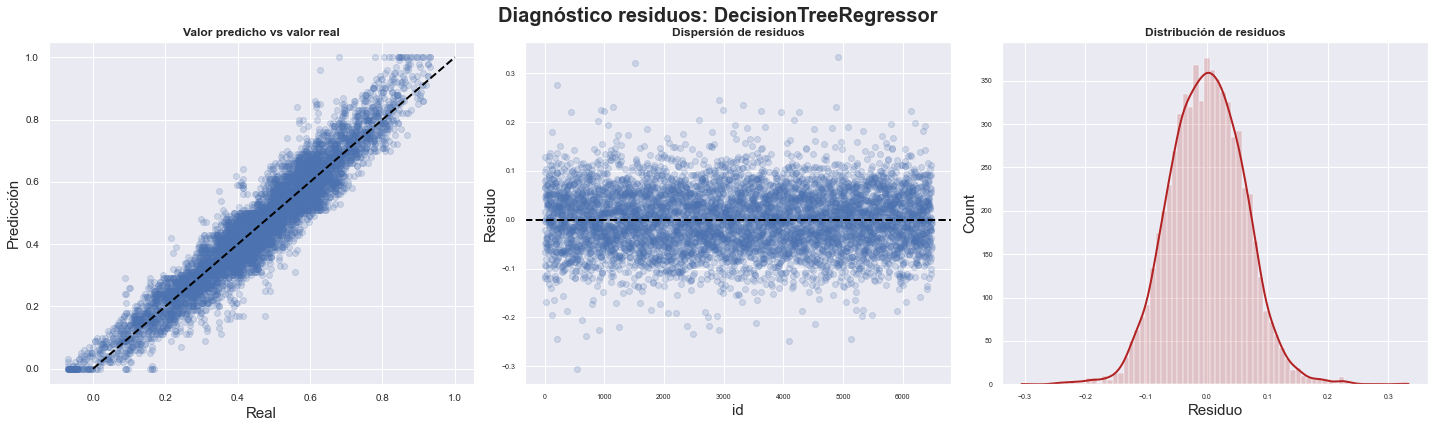

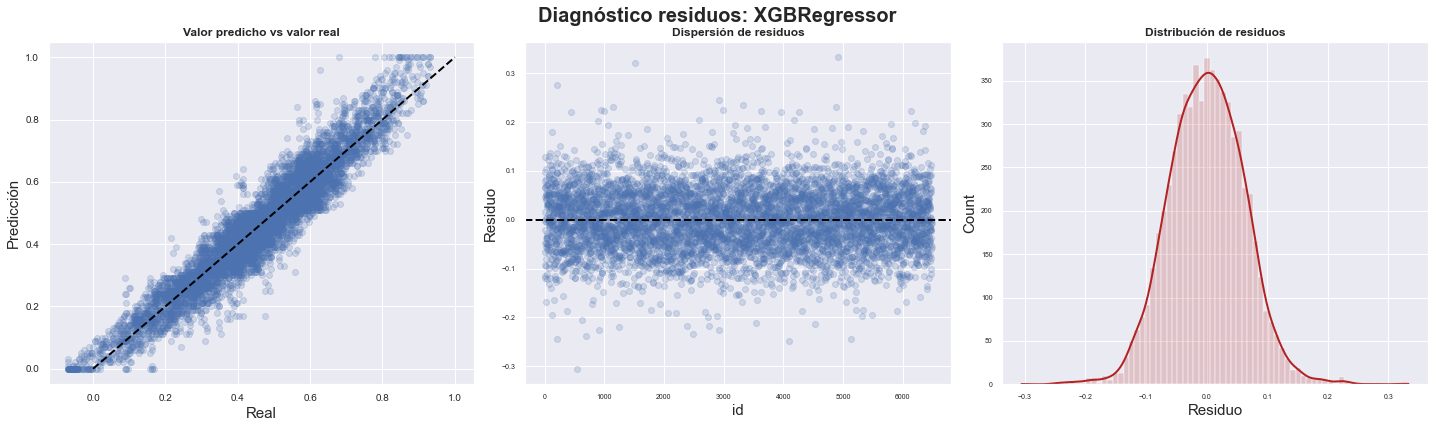

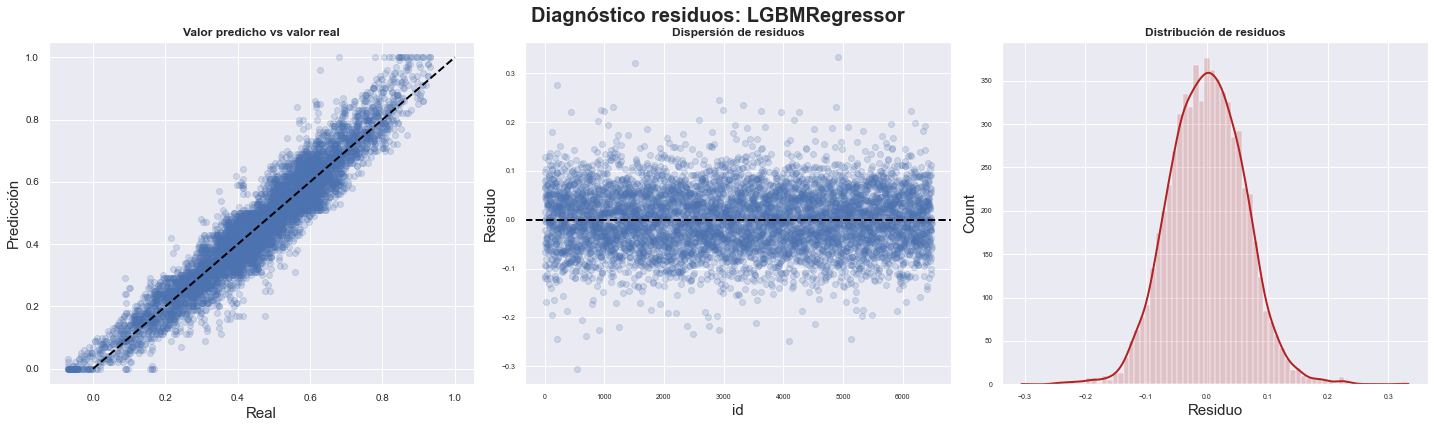

In [560]:
# Comparacion de residuos
plot_diagnostic(df)

# Residuos:

* La comparacion de los residuos de cada modelo es muy similar.

* La dispersion de los residuos nos muestran que la mayoria de los registros se encuentran entre -0,1 y 0,1.

* Al tener un Burn Rate que va del rango entre 0 y 1, podriamos tratar los valores fuera de los rangos de residuos entre -0,1 y 0,1.

In [561]:
df_ = df[['Nombre_modelo','R2','RMSE','MAE']].sort_values(by=['RMSE'],ascending=True)

df_

,Nombre_modelo,R2,RMSE,MAE
6,LGBMRegressor,0.917457,0.059065,0.039289
1,RandomForestRegressor,0.923246,0.059299,0.038805
5,XGBRegressor,0.924773,0.059651,0.039444
4,DecisionTreeRegressor,0.919891,0.060854,0.040000
0,LinearRegression,0.902022,0.061949,0.041659
3,GradientBoostingRegressor,0.935826,0.062826,0.040964
2,KNeighborsRegressor,0.922354,0.064303,0.040000


### <b>Conclusiones:</b>

#### *Notamos que casi todas las metricas utilizadas tiene una variablidad entre ellas por cada modelo muy bajo. Para nuestro modelo usaremos la metrica de RMSE ya que pretendemos generalizar el modelo basandonos en los resultados de nuestras predicciones, esta métrica nos indicara el intervalo en el cual pueden estar nuestras predicciones*

#### *Como podemos visualizar en la comparacion de las metricas el modelo LGBMRegressor tiene el RMSE mas bajo, por lo que usaremos este algortimo para nuestro proyecto*

# Hiper parámetros aplicado el modelo seleccionado

In [562]:
# Parámetros globales
num_estimators = np.linspace(100, 700, num = 10, endpoint = True).astype(int)
max_depth = rn.sample(range(1, 50), 20)
learning_rate = np.arange (0.001, 1, 0.005)
n_iter = rn.randint(50,150)

# Parámetros
params_global = {
    'n_estimators': num_estimators,
    'max_depth': max_depth, 
    'learning_rate': learning_rate
}

In [563]:
# Aplicacion de la tecnica RandomizedSearchCV
results = {}

# Modelo segun métrica tomado.
model = LGBMRegressor()

print(f'Start training {model.__class__.__name__}')

# Aplicación
modeling = RandomizedSearchCV(
    model, 
    params_global, 
    cv=10, 
    n_jobs=-1, 
    refit=True, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    n_iter=50
)

# Entrenamiento
modeling.fit(X_train_enc, y_train)

# Selección del modelo con refit 
best_model = modeling.best_estimator_

# Métrica de test
metrics_test = mean_squared_error(y_test, best_model.predict(X_test_enc),squared=False)

# Guardo resultados del mejor modelo.
results[best_model.__class__.__name__] = {
    'modelo': best_model,
    'score_train': modeling.best_score_ * -1,
    'score_test': metrics_test,
    'best_model_r2':r2_score(y_test,best_model.predict(X_test_enc)),
    'params': modeling.best_params_
}

Start training LGBMRegressor
Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [564]:
# Genero dataset con las comparaciones que tenia anteriormente y le agrego los resultados del hipertuning.
hipertuning_model = df_[ (df_['RMSE'].min())==df_['RMSE']]

for i in results:
    for a in results[f'{i}']:
        if a == 'params':
            hipertuning_model[f'{a}'] = [results[f'{i}'][f'{a}']]
            hipertuning_model['best_model_metric_RMSE'] = results[f'{i}']['score_test']
            hipertuning_model['best_model_r2'] = results[f'{i}']['best_model_r2']

In [565]:
# Vista de resultados con hipertuning.
hipertuning_model.T.rename(columns={6:'valores'})

,valores
Nombre_modelo,LGBMRegressor
R2,0.917457
RMSE,0.059065
MAE,0.039289
params,"{'n_estimators': 300, 'max_depth': 2, 'learnin..."
best_model_metric_RMSE,0.059352
best_model_r2,0.910333


In [566]:
# Parámetros del mejor modelo de LGBMRegressor
for i in hipertuning_model.params:
    print(i)

{'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.846}


# Conclusiones:

#### Para el modelo seleccionado por la metrica RMSE, LGBMRegressor, los mejores parámetros para obtener el menor erro de la raíz cuadrada del error cuadrático medio serian:

* n_estimators : 100,
* max_depth : 26
* learning_rate : 0.066
